In [1]:
import numpy as np
import pandas as pd

In [27]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import clear_output

In [28]:
import glob

tables = {
    'orders': '/kaggle/input/test-recsys/kaggle_tab_1345/tab_1_orders.csv',
    'products': list(sorted(glob.glob('/kaggle/input/test-recsys/sbermarket_tab_2*/*'))),
    'categories': '/kaggle/input/test-recsys/kaggle_tab_1345/tab_3_categories.csv',
    'users': '/kaggle/input/test-recsys/kaggle_tab_1345/tab_4_user_profiles.csv',
    'product_properties': '/kaggle/input/test-recsys/kaggle_tab_1345/tab_5_product_properties.csv',
    'cities': '/kaggle/input/test-recsys/tab_6_city.csv',
    'sample_submission': '/kaggle/input/test-recsys/sample_submission.csv',
}

In [29]:
orders = pd.read_csv('/kaggle/input/test-recsys/kaggle_tab_1345/tab_1_orders.csv')
user_profiles = pd.read_csv('/kaggle/input/test-recsys/kaggle_tab_1345/tab_4_user_profiles.csv')
product_properties = pd.read_csv('/kaggle/input/test-recsys/kaggle_tab_1345/tab_5_product_properties.csv')
categories = pd.read_csv('/kaggle/input/test-recsys/kaggle_tab_1345/tab_3_categories.csv')
city = pd.read_csv('/kaggle/input/test-recsys/tab_6_city.csv')
# products = pd.read_csv('/kaggle/input/test-recsys/sbermarket_tab_2_6/tab_2_products_2020-08-08.csv')

# Users

In [30]:
tickets_all = pd.DataFrame()
for product_path in list(sorted(glob.glob('/kaggle/input/test-recsys/sbermarket_tab_2*/*'))):
    print(product_path)
    products = pd.read_csv(product_path)
    products['amount'] = 1
    cash =  lambda x: (x * products.loc[x.index]['quantity']).sum()
    tickets = products.groupby(by = ['user_id', 'order_id']).agg({
                                                                'price': cash,
                                                                'amount': sum
                                                                })
    tickets_all = pd.concat([tickets_all, tickets])

tickets_mean = tickets_all.groupby('user_id').mean()#.drop(columns = 'order_id')
tickets_mean
tickets_mean.reset_index().to_csv('./tickets_means.csv', index = False)

/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-01-01.csv
/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-01-11.csv
/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-01-21.csv
/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-01-31.csv
/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-02-10.csv
/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-02-20.csv
/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-03-01.csv
/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-03-11.csv
/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-03-21.csv
/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-03-31.csv
/kaggle/input/test-recsys/sbermarket_tab_2_2/tab_2_products_2020-04-10.csv
/kaggle/input/test-recsys/sbermarket_tab_2_2/tab_2_products_2020-04-20.csv
/kaggle/input/test-recsys/sbermarket_tab_2_2/tab_2_products_2020-04-30.csv
/kaggle/input/test-recsys

In [31]:
tickets_mean

,price,amount
user_id,,
51,17875.070558,48.941176
65,7872.709124,36.521739
83,5894.309998,34.000000
142,3781.000000,1.000000
187,554.220001,2.000000
...,...,...
3142901,1135.339996,4.000000
3142924,1397.950039,8.000000
3142936,1380.300018,9.000000


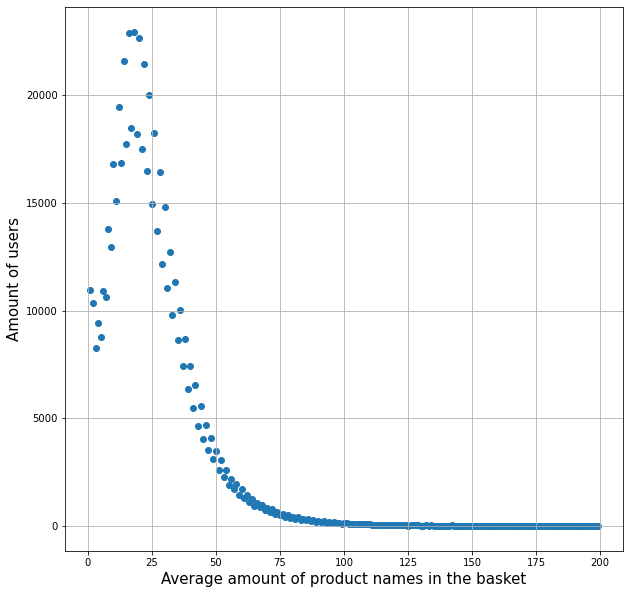

In [32]:
for_plot = tickets_mean.amount.round().value_counts().to_frame()
for_plot.index = for_plot.index.to_numpy().round(0)
for_plot = for_plot.reset_index().groupby('index').sum()
for_plot = for_plot[for_plot.index<200]
plt.figure(figsize=(10,10))
plt.scatter(for_plot.index, for_plot.amount)
plt.xlabel('Average amount of product names in the basket', fontsize=15)
plt.ylabel('Amount of users', fontsize=15)
plt.grid()

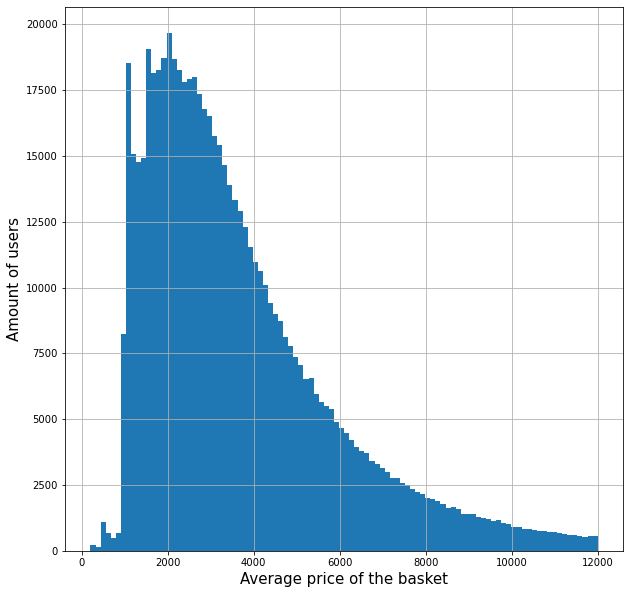

In [33]:
tickets_sub = tickets_mean[tickets_mean.price<12000]
plt.figure(figsize=(10,10))
# plt.hist(tickets_mean.price, bins= 100)
plt.hist(tickets_sub.price, bins= 100)
clear_output()
plt.xlabel('Average price of the basket', fontsize=15)
plt.ylabel('Amount of users', fontsize=15)
plt.grid()

# Products

## Popularity

In [34]:
product_freqs = products.groupby(['product_id'])['order_id'].count().reset_index()
product_freqs.columns = ['product_id', 'cnt']
product_freqs = product_freqs.sort_values('cnt', ascending=False)
print(product_freqs.cnt.sum())
product_freqs
product_freqs.reset_index().to_csv('./product_counts.csv', index = False)

3167955


In [35]:
product_popularity = product_freqs.reset_index()

In [39]:
product_popularity

,index,product_id,cnt
0,0,0,20757
1,171,709,14040
2,8178,39590,12023
3,60,166,10058
4,70,180,8353
...,...,...,...
72217,50045,6748083,1
72218,50040,6748076,1
72219,50038,6748071,1
72220,4502,18599,1


## Shelf life

In [36]:
import re

only_words = re.compile(r'[а-яА-Я]{1,}')
only_numbers = re.compile(r'[0-9]{1,}')

shelf_life = product_properties[product_properties.property_name == 'Срок хранения'].drop(columns = ['property_name']).rename(columns = {'property_value': 'shelf_life'}).reset_index(drop = True)

def parse_time(string):
    """Принимает на вход строку, возращает сутки"""
    if not isinstance(string, str):
        return 0
             
    if  bool(re.search(r'\d', string)):  
        
        time = int(only_numbers.findall(string)[0])

        if 'лет' in string or 'год' in string or ('г' in string and len(only_words.findall(string))==1) or ('л' in string and len(only_words.findall(string))==1):
            return float(time * 365)

        elif 'мес' in string:
            return float(time * 30)

        elif 'нед' in string:
                return float(time * 7)

        elif 'сут' in string or 'день' in string or 'дней' in string or 'дня' in string or ('д' in string and len(only_words.findall(string))==1):
            return float(time)

        elif 'час' in string or ('ч' in string and len(only_words.findall(string))==1):
            return float(time / 24)

        else:
            return 0
        
    if  'Не ор' in string or 'Не ог' in string or 'Неог' in string or 'Бессроч' in string:
        return -1
    else:
        return 0

shelf_life.shelf_life = list(map(parse_time, shelf_life.shelf_life))

shelf_life.to_csv('./shelf_life.csv', index = False)

In [37]:
shelf_life

,product_id,shelf_life
0,6,32.0
1,8,32.0
2,9,32.0
3,10,35.0
4,11,30.0
...,...,...
266387,15016304,1800.0
266388,15016342,-1.0
266389,15016345,-1.0
266390,15016346,-1.0


## Additional features

In [40]:
products_additional = pd.DataFrame()
for product_path in list(sorted(glob.glob('/kaggle/input/test-recsys/sbermarket_tab_2*/*'))):
    print(product_path)
    products = pd.read_csv(product_path)
    additional_features = products[['product_id', 'master_category_id', 'parent_category_id']].drop_duplicates().reset_index(drop=True)
    products_additional = pd.concat([products_additional, additional_features])
products_additional.drop_duplicates(inplace = True)
products_additional.to_csv('./products_additional.csv', index = False)

/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-01-01.csv
/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-01-11.csv
/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-01-21.csv
/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-01-31.csv
/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-02-10.csv
/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-02-20.csv
/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-03-01.csv
/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-03-11.csv
/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-03-21.csv
/kaggle/input/test-recsys/sbermarket_tab_2_1/tab_2_products_2020-03-31.csv
/kaggle/input/test-recsys/sbermarket_tab_2_2/tab_2_products_2020-04-10.csv
/kaggle/input/test-recsys/sbermarket_tab_2_2/tab_2_products_2020-04-20.csv
/kaggle/input/test-recsys/sbermarket_tab_2_2/tab_2_products_2020-04-30.csv
/kaggle/input/test-recsys

In [41]:
products_additional

,product_id,master_category_id,parent_category_id
0,37548,101.0,99
1,5636,596.0,51
2,22107,596.0,51
3,2530,77.0,74
4,3818486,76.0,74
...,...,...,...
72175,9267512,574.0,9
72179,7342931,574.0,9
72188,9963222,262.0,252
72215,9260539,343.0,290


In [42]:
product_table = pd.merge(left = shelf_life, right = products_additional, on = 'product_id', how = 'right')
product_table = pd.merge(left = product_table, right = product_popularity, on = 'product_id', how = 'right')

In [43]:
product_table['shelf_life'] = product_table['shelf_life'].fillna(value=0)
product_table.to_csv('./product_table.csv', index = False)
product_table

,product_id,shelf_life,master_category_id,parent_category_id,index,cnt
0,0,0.0,NaN,0,0,20757
1,709,6.0,91.0,90,171,14040
2,39590,30.0,29.0,20,8178,12023
3,166,10.0,26.0,20,60,10058
4,180,180.0,26.0,20,70,8353
...,...,...,...,...,...,...
72219,6748083,4.0,124.0,119,50045,1
72220,6748076,180.0,123.0,119,50040,1
72221,6748071,180.0,110.0,99,50038,1
72222,18599,150.0,22.0,20,4502,1


# Discounts

Here we check if the product has a discount in the reatailors of a particular city

In [46]:
tab_1_orders = pd.read_csv('/kaggle/input/test-recsys/kaggle_tab_1345/tab_1_orders.csv')
tab_2_products_0907 = pd.read_csv('/kaggle/input/test-recsys/sbermarket_tab_2_6/tab_2_products_2020-09-07.csv')
# tab_4_user_profiles = pd.read_csv('/kaggle/input/test-recsys/kaggle_tab_1345/tab_4_user_profiles.csv')
# tab_5_product_properties = pd.read_csv('/kaggle/input/test-recsys/kaggle_tab_1345/tab_5_product_properties.csv')
# tab_3_categories = pd.read_csv('/kaggle/input/test-recsys/kaggle_tab_1345/tab_3_categories.csv')
tab_6_city = pd.read_csv('/kaggle/input/test-recsys/tab_6_city.csv')

In [47]:
tb_merge = pd.merge(tab_2_products_0907[['user_id', 'order_id', 'discount', 'product_id']], pd.merge(tab_1_orders[['order_id', 'retailer', 'store_id']], tab_6_city, on = 'store_id', how = 'inner'), on = 'order_id', how = 'inner').drop(columns = 'store_id')

In [48]:
tb_merge.discount[tb_merge.discount <= 0] = 0
tb_merge.discount[tb_merge.discount > 0] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
disc_tab = tb_merge.drop(columns = ['user_id', 'order_id']).drop_duplicates().groupby(['product_id','city_name','retailer'])['discount'].mean().reset_index()

In [50]:
disc_tab

,product_id,city_name,retailer,discount
0,0,Абакан,Аллея,0.0
1,0,Альметьевск,Лента,0.5
2,0,Анадырь,"ТЦ ""Новомариинский""",0.0
3,0,Архангельск,METRO,0.5
4,0,Архангельск,Лента,0.5
...,...,...,...,...
830256,13550935,Московская Область,METRO,0.0
830257,13550935,Санкт-Петербург,METRO,0.0
830258,13550945,Казань,METRO,0.0
830259,13550974,Новосибирск,METRO,0.0


0 - no discount
0.5 - discount in some stores
1 - discount